In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import sys
import cv2
import os
import numpy as np
import torch

import re


from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Function to clear given folder paths (direct parent folders)

In [ ]:
# Function to clean a folder of bitmap files
def clean_folder(folder_path):

    if not os.path.exists(folder_path):
        print(f"Folder '{folder_path}' does not exist.")
        return

    print(os.listdir(folder_path))
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # Check if the file is a bitmap (assuming file extension is '.bmp')
        if filename.endswith('.bmp'):
            # Delete the bitmap file
            os.remove(file_path)


Function calls to clear generated folders and images.

In [ ]:
# clean_folder("/content/drive/MyDrive/CSE 144 Group 7/archive/Brain_Tumor_Datasets_Classified/test/Glioma")
# clean_folder("/content/drive/MyDrive/CSE 144 Group 7/archive/Brain_Tumor_Datasets_Classified/train/Glioma")

# clean_folder("/content/drive/MyDrive/CSE 144 Group 7/archive/Brain_Tumor_Datasets_Classified/test/Pituitary_Adenoma")
# clean_folder("/content/drive/MyDrive/CSE 144 Group 7/archive/Brain_Tumor_Datasets_Classified/train/Pituitary_Adenoma")

# clean_folder("/content/drive/MyDrive/CSE 144 Group 7/archive/Brain_Tumor_Datasets_Classified/test/Meningioma")
# clean_folder("/content/drive/MyDrive/CSE 144 Group 7/archive/Brain_Tumor_Datasets_Classified/train/Meningioma")

# clean_folder("/content/drive/MyDrive/CSE 144 Group 7/archive/Brain_Tumor_Datasets_Classified/test/Unknown")
# clean_folder("/content/drive/MyDrive/CSE 144 Group 7/archive/Brain_Tumor_Datasets_Classified/train/Unknown")

# clean_folder("/content/drive/MyDrive/CSE 144 Group 7/archive/Brain_Tumor_Datasets_Classified/test/No")
# clean_folder("/content/drive/MyDrive/CSE 144 Group 7/archive/Brain_Tumor_Datasets_Classified/train/No")

Function to split collected training and testing data into classified seperated folders.

In [ ]:
def split_into_classes(input_folder: str, output_folder_parent: str, no: bool = False) -> None:
    # Ensure the output folder exists
    os.makedirs(output_folder_parent, exist_ok=True)

    # List all files in the input folder
    jpg_files: list[str] = os.listdir(input_folder)

    print("all files: ", jpg_files)

    # Iterate over each jpg file
    for i,jpg_file in enumerate(jpg_files):
        # # Make sure it is working
        # if i > 5:
        #   return

        # Check if the file is a jpg image
        if jpg_file.lower().endswith('.jpg'):
            # Construct the full path to the jpg file
            jpg_file: str = os.path.basename(jpg_file)
            jpg_file_path: str = os.path.join(input_folder, jpg_file)

            # Load image
            image = cv2.imread(jpg_file_path)

            output_folder: str = output_folder_parent

            # Check which class image belongs to, if there is a tumor
            if not no:

              # Define all tumor types to check for
              pattern_Glioma = r'(gl)'
              pattern_Pituitary_Adenoma = r'(pi)'
              pattern_Meningioma = r'(me)'

              # Use patterns to find which type of cancer
              found_Glioma = re.search(pattern_Glioma, jpg_file)
              found_Pituitary_Adenoma = re.search(pattern_Pituitary_Adenoma, jpg_file)
              found_Meningioma = re.search(pattern_Meningioma, jpg_file)

              # Select output folder name based on tumor class
              if found_Glioma:
                output_folder += '/Glioma'
              elif found_Pituitary_Adenoma:
                output_folder += '/Pituitary_Adenoma'
              elif found_Meningioma:
                output_folder += '/Meningioma'
              else:
                output_folder += '/Unknown'

            else:
              output_folder += '/No'

            # Make dir if it does not exist:
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

            # Construct the output file path
            output_file_path = os.path.join(output_folder, jpg_file)

            # Check if the file already exists in the output folder
            if not os.path.exists(output_file_path):
                # Save the image as a jpg file
                cv2.imwrite(output_file_path, image)


Function calls to brain tumor data to make a new data folder with data classified based on tumor type.

In [ ]:
# # Path to the folder containing PNG images to classify
# input_folder: str = "/content/drive/MyDrive/CSE 144 Group 7/archive/Brain_Tumor_Datasets"

# # Path to the parent folder where you want to save the classified images
# output_folder: str = "/content/drive/MyDrive/CSE 144 Group 7/archive/Brain_Tumor_Datasets_Classified"

# # Sort jpg images into class folders for test/no and test/yes folders
# split_into_classes(os.path.join(input_folder, "test/no"), os.path.join(output_folder, "test"), True)
# split_into_classes(os.path.join(input_folder, "test/yes"), os.path.join(output_folder, "test"))

# # Sort jpg images into class folders for test/no and test/yes folders
# split_into_classes(os.path.join(input_folder, "train/no"), os.path.join(output_folder, "train"), True)
# split_into_classes(os.path.join(input_folder, "train/yes"), os.path.join(output_folder, "train"))

Code block to transport data into datasets and dataloaders.

In [ ]:
# Path to your image folders
data_path_test = "/content/drive/MyDrive/CSE 144 Group 7/archive/Brain_Tumor_Datasets_Classified/test"
data_path_train = "/content/drive/MyDrive/CSE 144 Group 7/archive/Brain_Tumor_Datasets_Classified/train"

# Define transformations for training and testing datasets
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),     # Resize the image to 64x64
    transforms.ToTensor()            # Convert the image to a PyTorch tensor
])

# Create datasets
test_dataset = datasets.ImageFolder(root=data_path_test, transform=transform)
train_dataset = datasets.ImageFolder(root=data_path_train, transform=transform)

# Split the training data into train and validation sets
train_size = int(0.9 * len(train_dataset))  # 90% of the data for training
val_size = len(train_dataset) - train_size  # 10% of the data for validation
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 128
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Check the lengths
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

print(train_dataset[0][0].shape)
print(val_dataset[0][0].shape)
print(test_dataset[0][0].shape)

6210
691
1731
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])


6323
703
1760
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])

Check if cuda is avaliable if so use it

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Function definitions for training and testing data

In [ ]:
def evaluate_model(model, dataloader, is_test=False):
    # Evaluation

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        correct = 0
        loss = 0

        criterion = nn.NLLLoss()  # Use NLLLoss with log_softmax

        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            target = target.long()  # Ensure target is of type long
            outputs = model(data)

            loss += criterion(outputs, target).item()

            pred = outputs.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

        loss /= len(dataloader.dataset)
        accuracy = 100. * correct / len(dataloader.dataset)
        print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            "Test" if is_test else "Validation",
            loss, correct, len(dataloader.dataset),
            accuracy))
    # Set model back to training mode
    model.train()

def train_model(model, num_epochs, criterion, optimizer):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()  # Ensure labels are of type long

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # Print every 10 mini-batches
                print('[Epoch %d, Batch %5d] Loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0

        # Evaluate the model on the validation set after each epoch
        evaluate_model(model, valloader)

Definition of the CNN for multi-classification of brain tumors.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # Flatten the input
        self.flatten = nn.Flatten()

        # Define the dense layers
        self.fc1 = nn.Linear(128 * 64 * 64, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        # Apply ReLU activation after the convolutional layers
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))

        # Flatten the output of the convolutional layers
        x = self.flatten(x)

        # Apply dense layer 1
        x = nn.functional.relu(self.fc1(x))

        # Apply the dropout layer
        x = self.dropout(x)

        # Apply dense layer 2 and log_softmax
        x = nn.functional.log_softmax(self.fc2(x), dim=1)  # Apply log_softmax along the appropriate dimension

        return x


Hyper-parameters for calling the CNN model training and testing.

In [ ]:
learning_rate = 0.01
epochs = 10
batch_size = 128

model = CNN()
model.to(device)

criterion = torch.nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Test Non-Trained Model on Test Set")
evaluate_model(model, testloader, True)
print("Train Model")
train_model(model, epochs, criterion, optimizer)
print("Test Trained Model on Test Set")
evaluate_model(model, testloader)

Test Non-Trained Model on Test Set

Validation set: Average loss: 0.0112, Accuracy: 318/1731 (18%)

Train Model
[Epoch 1, Batch    10] Loss: 147.484
[Epoch 1, Batch    20] Loss: 1.381
[Epoch 1, Batch    30] Loss: 1.374
[Epoch 1, Batch    40] Loss: 1.359

Validation set: Average loss: 0.0116, Accuracy: 301/691 (44%)

[Epoch 2, Batch    10] Loss: 1.334
[Epoch 2, Batch    20] Loss: 1.328
[Epoch 2, Batch    30] Loss: 1.322
[Epoch 2, Batch    40] Loss: 1.324

Validation set: Average loss: 0.0114, Accuracy: 301/691 (44%)

[Epoch 3, Batch    10] Loss: 1.327
[Epoch 3, Batch    20] Loss: 1.319
[Epoch 3, Batch    30] Loss: 1.312
[Epoch 3, Batch    40] Loss: 1.316

Validation set: Average loss: 0.0114, Accuracy: 301/691 (44%)

[Epoch 4, Batch    10] Loss: 1.331
[Epoch 4, Batch    20] Loss: 1.319
[Epoch 4, Batch    30] Loss: 1.306
[Epoch 4, Batch    40] Loss: 1.304

Validation set: Average loss: 0.0114, Accuracy: 301/691 (44%)

[Epoch 5, Batch    10] Loss: 1.327
[Epoch 5, Batch    20] Loss: 1.322


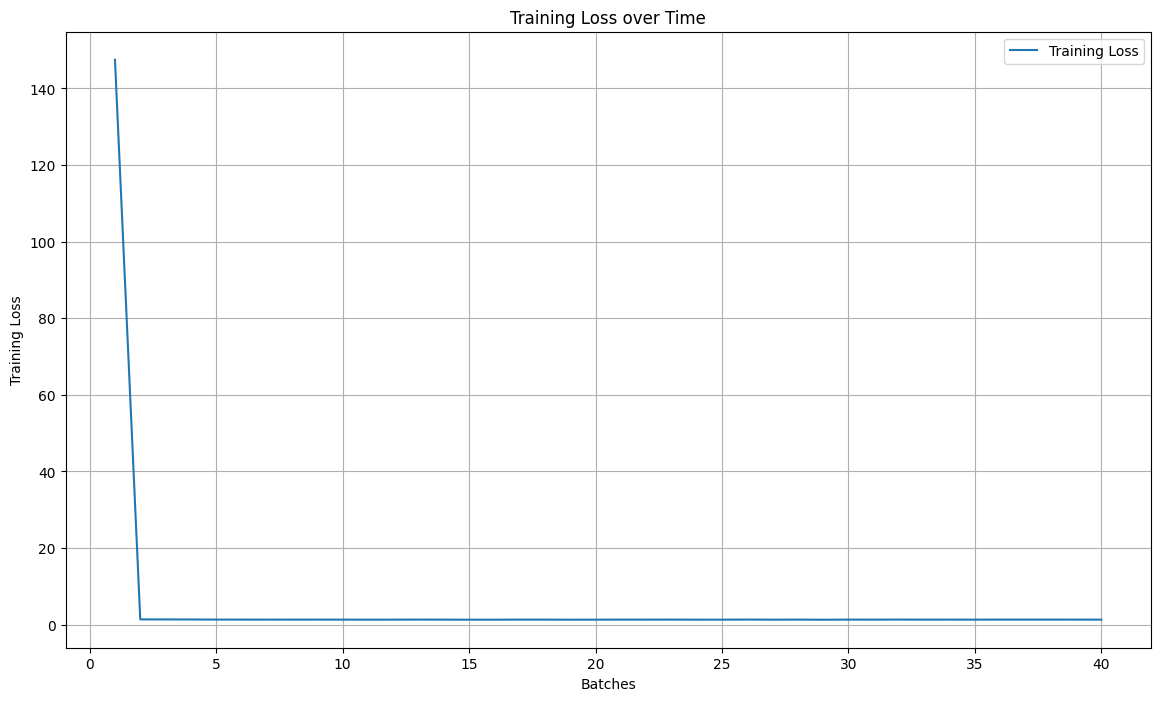

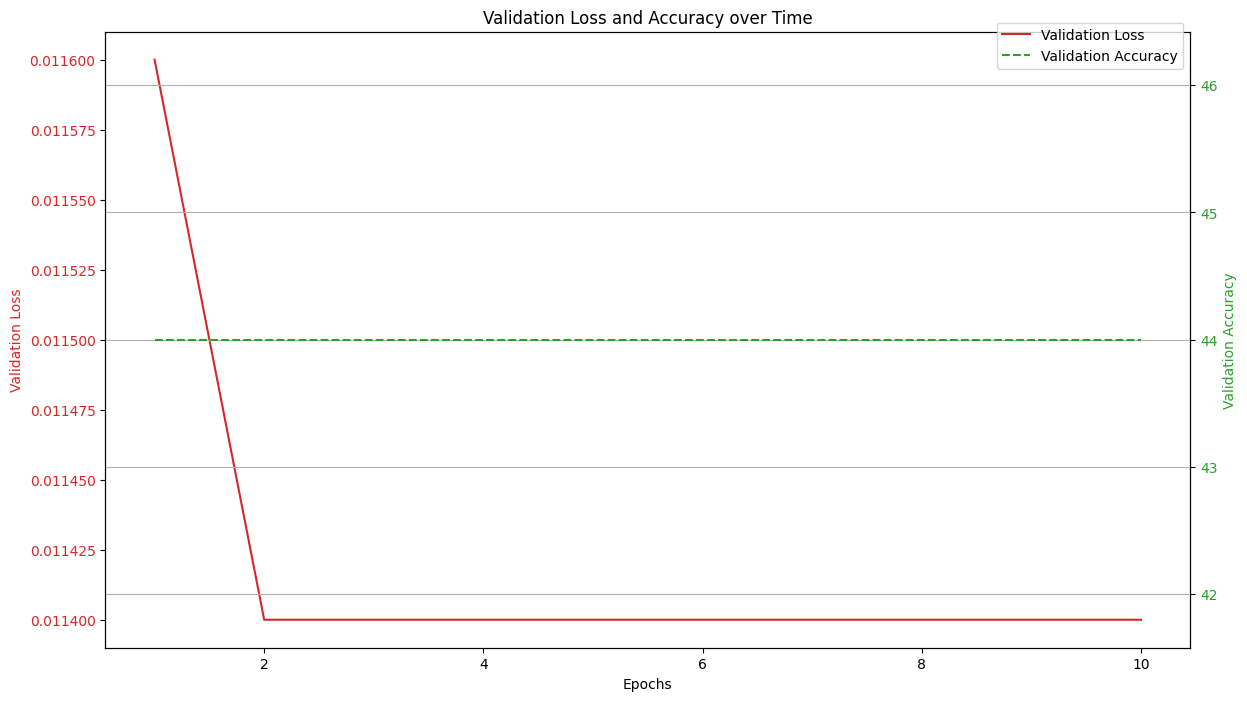

In [4]:
import matplotlib.pyplot as plt

# Training and validation metrics
train_loss_batches = {
    1: [147.484, 1.381, 1.374, 1.359],
    2: [1.334, 1.328, 1.322, 1.324],
    3: [1.327, 1.319, 1.312, 1.316],
    4: [1.331, 1.319, 1.306, 1.304],
    5: [1.327, 1.322, 1.304, 1.311],
    6: [1.326, 1.320, 1.329, 1.313],
    7: [1.314, 1.334, 1.312, 1.325],
    8: [1.297, 1.326, 1.318, 1.335],
    9: [1.319, 1.322, 1.315, 1.329],
    10: [1.328, 1.328, 1.326, 1.314]
}

val_loss = [0.0116, 0.0114, 0.0114, 0.0114, 0.0114, 0.0114, 0.0114, 0.0114, 0.0114, 0.0114]
val_accuracy = [44, 44, 44, 44, 44, 44, 44, 44, 44, 44]

epochs = list(train_loss_batches.keys())
batches = range(1, 41, 10)

# Flatten train loss for plotting
train_loss = [loss for epoch in train_loss_batches.values() for loss in epoch]

# Create figure for training loss
fig1, ax1 = plt.subplots(figsize=(14, 8))
ax1.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='tab:blue')
ax1.set_xlabel('Batches')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss over Time')
ax1.grid()
ax1.legend()

# Create figure for validation metrics
fig2, ax2 = plt.subplots(figsize=(14, 8))
ax2.plot(epochs, val_loss, label='Validation Loss', color='tab:red')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Create a twin Axes sharing the xaxis
ax3 = ax2.twinx()
ax3.plot(epochs, val_accuracy, label='Validation Accuracy', color='tab:green', linestyle='dashed')
ax3.set_ylabel('Validation Accuracy', color='tab:green')
ax3.tick_params(axis='y', labelcolor='tab:green')

fig2.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.title('Validation Loss and Accuracy over Time')
plt.grid()

# Show plots
plt.show()
